In [428]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [429]:
# 计算成对的欧式距离
def pairwise_distances(Data):
    return np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))

def k_nearest_neighbors(Data, n_neighbors):
    dist_matrix = pairwise_distances(Data)
    return np.argsort(dist_matrix, axis=1)[:, 1:n_neighbors + 1]

In [430]:
# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(Data): 
    n = Data.shape[0] # 数据集的大小
    dist_matrix = pairwise_distances(Data) # 计算成对的欧式距离
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(dist_matrix[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    np.savetxt('dist_matrix.csv', dist_matrix, delimiter=',')
    np.savetxt('average_radius.csv', radius, delimiter=',')
    return radius

In [431]:
import heapq

# 使用优先队列（堆）实现 Dijkstra 算法
def dijkstra_shortest_path(graph, start):
    n = graph.shape[0]
    distances = np.full(n, np.inf)
    distances[start] = 0
    pq = [(0, start)]  # 优先队列，存储节点和对应的距离
    while pq:
        dist, current = heapq.heappop(pq)  # 弹出距离最小的节点
        if dist > distances[current]:
            continue
        for neighbor, weight in enumerate(graph[current]):
            if weight > 0 and dist + weight < distances[neighbor]:
                distances[neighbor] = dist + weight
                heapq.heappush(pq, (dist + weight, neighbor))  # 更新距离并入队
    return distances

In [432]:
Pi = 3.14159265358979323846

# 计算k最近邻矩阵的邻接矩阵
def knn_to_adjacency(knn_matrix):
    n = knn_matrix.shape[0]
    knn_adjacency_matrix = np.zeros((n, n))
    for i in range(n):
        for j in knn_matrix[i]:
            knn_adjacency_matrix[i, j] = 1
            knn_adjacency_matrix[j, i] = 1
    return knn_adjacency_matrix

def adjacency_to_knn(Data, adjacency_matrix):
    n = len(Data)
    knn_matrix = np.zeros_like(adjacency_matrix, dtype=int)
    for i in range(n):
        neighbor_indices = np.where(adjacency_matrix[i] == 1)[0]  # 找到邻接矩阵中为1的索引
        knn_matrix[i, :len(neighbor_indices)] = neighbor_indices  # 将邻接矩阵中为1的索引保存到 knn_matrix 中
    return knn_matrix




# 计算k最近邻矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, n_neighbors):
    n = len(Data)
    if method == 'knn':
        knn_matrix = k_nearest_neighbors(Data, n_neighbors)
        np.savetxt('knn_matrix1.csv', knn_matrix, delimiter=',')
        return knn_matrix
    elif method == 'epsilon':
        adjacency_matrix = np.zeros((n, n))
        radius = compute_avg_radius(Data)  # 计算每个数据点的邻域半径
        distances = pairwise_distances(Data)  # 计算点之间的距离
        neighbors = np.zeros((n, n))
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= radius[i])[0]  # 选择半径内的点作为邻居
            if len(neighbors) > n/2:  # 如果邻居数量超过 n/2
                sorted_indices = np.argsort(distances[i, neighbors])  # 根据距离排序邻居点的索引
                selected_neighbors = neighbors[sorted_indices[:int(n/2)]]  # 仅选择最近的 n/2 个点作为邻居
                adjacency_matrix[i, selected_neighbors] = 1 # 更新邻接矩阵
                adjacency_matrix[selected_neighbors, i] = 1 # 邻接矩阵为对称矩阵
            else:
                adjacency_matrix[i, neighbors] = 1
                adjacency_matrix[neighbors, i] = 1
        np.savetxt('epsilon_matrix.csv', adjacency_matrix, delimiter=',')
        return adjacency_matrix

In [433]:
# 将k最近邻矩阵的邻接矩阵和 epsilon 邻域矩阵相结合得到最佳邻接矩阵
def Best_adjacency_matrix(Data, knn_neighbors):
    # 计算k最近邻矩阵的邻接矩阵和 epsilon 邻域矩阵
    knn_matrix = compute_neighborhood_matrix(Data, 'knn', knn_neighbors)
    knn_adjacency_matrix = knn_to_adjacency(knn_matrix)
    epsilon_adjacency_matrix = compute_neighborhood_matrix(Data, 'epsilon', knn_neighbors)
    # 结合两种邻接矩阵得到最佳邻接矩阵
    best_adjacency_matrix = np.maximum(knn_adjacency_matrix, epsilon_adjacency_matrix)
    np.savetxt('best_adjacency_matrix.csv', best_adjacency_matrix, delimiter=',')
    np.savetxt('knn_adjacency_matrix.csv', knn_adjacency_matrix, delimiter=',')
    np.savetxt('epsilon_adjacency_matrix.csv', epsilon_adjacency_matrix, delimiter=',')
    return best_adjacency_matrix

In [434]:
# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, n_neighbors, t):
    neighborhood_matrix = Best_adjacency_matrix(Data, n_neighbors)
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    if method == 'knn':
        dist_matrix = pairwise_distances(Data)
        knn_matrix = adjacency_to_knn(Data, neighborhood_matrix)
        np.savetxt('knn_matrix2.csv', knn_matrix, delimiter=',')
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in knn_matrix[i]:  # 对于样本点 i 的邻居点 j
                Weight_matrix[i][int(j)] = np.exp(-dist_matrix[i][int(j)] ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 使用热核方法计算权重
                Weight_matrix[int(j)][i] = np.exp(-dist_matrix[int(j)][i] ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 邻接矩阵为对称矩阵
        np.savetxt('knn_weight_matrix.csv', Weight_matrix, delimiter=',')
    elif method == 'epsilon':
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if neighborhood_matrix[i, j] == 1:  # 如果样本点 j 在第i个样本点的epsilon邻域内
                    distance = np.linalg.norm(Data[i] - Data[j])  # 计算样本点 i 和 j 之间的距离（欧式距离）
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 邻接矩阵为对称矩阵
        np.savetxt('epsilon_weight_matrix.csv', Weight_matrix, delimiter=',')
    return Weight_matrix

In [435]:
# 进行特征映射
def eigen_mapping(Laplacian_matrix, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = eigh(Laplacian_matrix)
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    return selected_eigenvectors

In [436]:
# LPP 算法
def LPP(Data, n_components, method, n_neighbors, t):
    # Step 1: 构建基于权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, n_neighbors, t)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    selected_eigenvectors = eigen_mapping(Laplacian_matrix, n_components)
    return selected_eigenvectors

In [437]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)

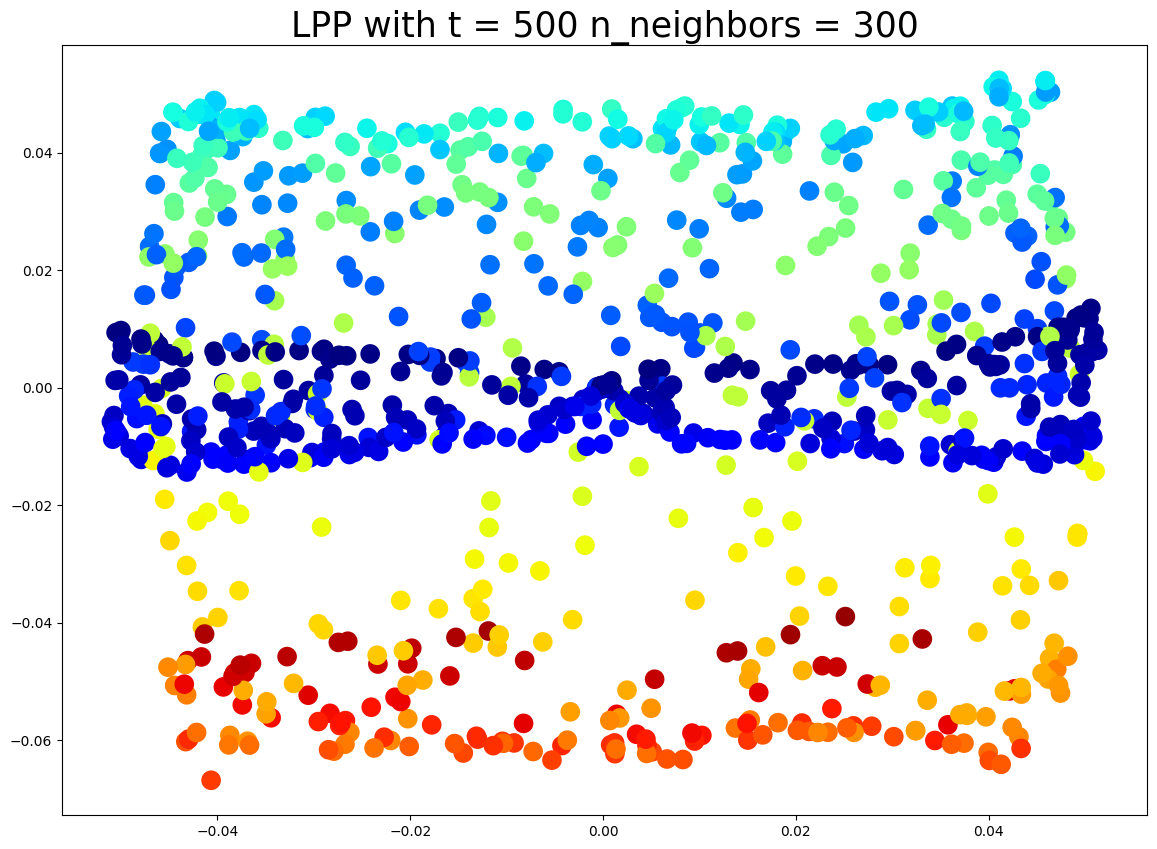

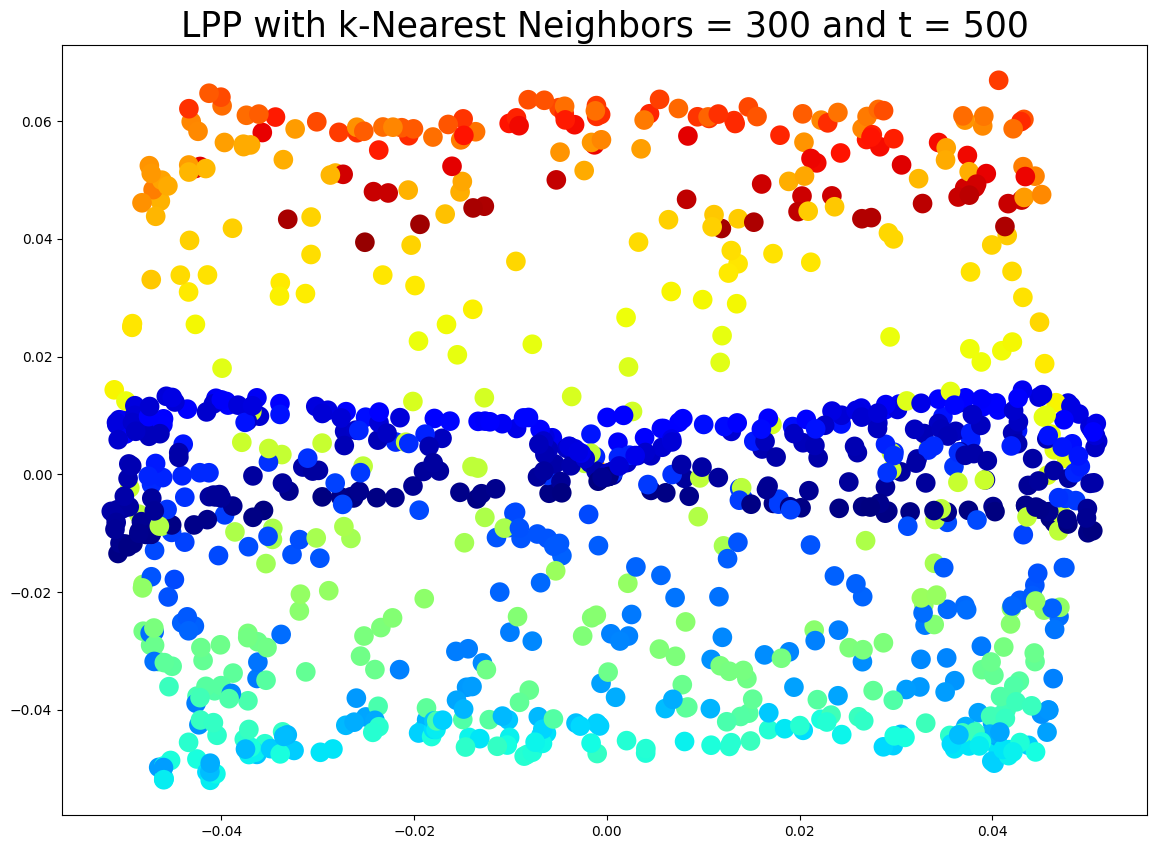

In [438]:
# 绘制及保存投影图
if not os.path.exists('output'):
    os.makedirs('output')
for method in ['epsilon', 'knn']:
    plt.figure(figsize=(14, 10))
    if method == 'epsilon':
        t= 500
        n_neighbors = 300
        lpp_embeddings = LPP(Data_T, n_components=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP with t = ' + str(t) + ' n_neighbors = ' + str(n_neighbors), size=25)
        file_name = 'LPP_epsilon_t = ' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    elif method == 'knn':
        n_neighbors = 300
        t= 500
        lpp_embeddings = LPP(Data_T, n_components=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_knn_' + str(n_neighbors) + '_t=' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    plt.show()


In [439]:
# MDS 算法实现
def MDS(distances, n_components):
    n = distances.shape[0]  # 获取数据集的大小
    J = np.eye(n) - np.ones((n, n)) / n  # 计算中心化矩阵 J
    B = -0.5 * J.dot(distances ** 2).dot(J)  # 计算矩阵 B
    eigenvalues, eigenvectors = np.linalg.eigh(B)  # 计算特征值和特征向量

    # 对特征值和特征向量进行排序
    indices = np.argsort(eigenvalues)[::-1]  # 获取特征值降序排列的索引
    eigenvalues = eigenvalues[indices]  # 根据索引重新排序特征值
    eigenvectors = eigenvectors[:, indices]  # 根据索引重新排序特征向量

    # 选择前 n_components 个特征值和对应的特征向量
    eigenvalues = eigenvalues[:n_components]  # 选择前 n_components 个特征值
    eigenvectors = eigenvectors[:, :n_components]  # 选择对应的特征向量

    # 计算降维后的结果
    embeddings = eigenvectors.dot(np.diag(np.sqrt(eigenvalues)))  # 计算降维后的嵌入结果
    return embeddings  # 返回嵌入结果

def LPP_Isomap(Data, n_components, n_neighbors):
    # 使用迪杰斯特拉算法计算最短路径并得到成对的测地距离 shortest_paths
    shortest_paths = np.zeros((len(Data), len(Data)))
    for i in range(len(Data)):
        shortest_paths[i] = dijkstra_shortest_path(Best_adjacency_matrix(Data, n_neighbors), i)
    embeddings = MDS(shortest_paths, n_components)
    return embeddings
'''
Embeddings = LPP_Isomap(Data_T, n_components = 2, n_neighbors = 10)
# 绘制 Isomap 投影图
plt.figure(figsize=(14,10))
plt.scatter(Embeddings[:, 0], Embeddings[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('Isomap with k-Nearest Neighbors = ' + str(n_neighbors), size=30)
plt.axis("off")
plt.show()
'''

'\nEmbeddings = LPP_Isomap(Data_T, n_components = 2, n_neighbors = 10)\n# 绘制 Isomap 投影图\nplt.figure(figsize=(14,10))\nplt.scatter(Embeddings[:, 0], Embeddings[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)\nplt.title(\'Isomap with k-Nearest Neighbors = \' + str(n_neighbors), size=30)\nplt.axis("off")\nplt.show()\n'